In [ ]:
!pip install seaborn

In [ ]:
!pip install pillow

In [ ]:
!pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.0 MB/s eta 0:00:00


In [ ]:
from posix import read
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
import os
from pathlib import Path
import shutil
from PIL import Image
import io
import subprocess
from google.colab import drive

def mount_drive():
    """Mount Google Drive"""
    drive.mount('/content/drive', force_remount=True)
    print("Drive mounted successfully")

def clean_filename(filename):
    """Remove spaces and special characters from filename"""
    # Split name and extension
    base, ext = os.path.splitext(filename)
    # Replace spaces with underscores and remove other special characters
    cleaned_base = base.replace(' ', '_').replace('-', '_')
    # Return cleaned filename
    return f"{cleaned_base}{ext}"

def generate_new_filename(category, filename):
    """
    Generate new filename based on category
    Format: Category_CleanedFilename
    Always returns with .jpg extension
    """
    # First clean the filename (remove spaces, etc.)
    cleaned_name = clean_filename(filename)
    # Split name and extension
    base, ext = os.path.splitext(cleaned_name)

    # Check if the filename already starts with the category
    if base.startswith(f"{category}_"):
        base = base
    else:
        base = f"{category}_{base}"

    # Always use jpg extension
    return f"{base}.jpg"

def sort_tomatoes(source_dir, output_dir):
    """
    Sort and rename tomato images based on their categories
    """
    # List of all categories
    categories = [
        'OverRipe', 'Ripe',
        'Unripe', 'VeryRipe'
    ]

    # Process each split (valid, train, test)
    for split in ['test', 'train', 'valid']:
        print(f"\nProcessing {split} split...")

        # Setup paths
        split_source = os.path.join(source_dir, split)
        split_output = os.path.join(output_dir, split)

        if not os.path.exists(split_source):
            print(f"Warning: Source directory {split_source} not found")
            continue

        # Create output category directories
        for category in categories:
            os.makedirs(os.path.join(split_output, category), exist_ok=True)

        # Process each category in the source
        for category in os.listdir(split_source):
            category_path = os.path.join(split_source, category)
            if not os.path.isdir(category_path):
                continue

            print(f"Processing category: {category}")

            # Process each image in the category
            for filename in os.listdir(category_path):
                if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):
                    continue

                source_path = os.path.join(category_path, filename)
                dest_folder = os.path.join(split_output, category)

                # Generate new filename using the category
                new_filename = generate_new_filename(category, filename)

                # Show renaming information
                if new_filename != filename:
                    print(f"Renaming: {filename} → {new_filename}")

                dest_path = os.path.join(dest_folder, new_filename)

                try:
                    # Check if we need to convert the image
                    if filename.lower().endswith('.heic'):
                        try:
                            # Try to use pillow-heif if available
                            try:
                                import pillow_heif
                                heif_file = pillow_heif.read_heif(source_path)
                                img = Image.frombytes(
                                    heif_file.mode,
                                    heif_file.size,
                                    heif_file.data,
                                    "raw",
                                    heif_file.mode
                                )
                                img.save(dest_path, 'JPEG', quality=90)
                                print(f"Converted {filename} to JPG using pillow-heif")
                            except (ImportError, Exception) as e:
                                # If pillow-heif fails, just copy the file without conversion
                                print(f"HEIC conversion failed, copying without conversion: {str(e)}")
                                # But still rename with .jpg extension for consistency
                                shutil.copy2(source_path, dest_path)
                        except Exception as e:
                            print(f"Error handling {filename}: {str(e)}")
                            # Still try to copy the file to maintain dataset completeness
                            shutil.copy2(source_path, dest_path)
                    elif filename.lower().endswith('.png'):
                        try:
                            # Open and convert PNG to JPG
                            with Image.open(source_path) as img:
                                # Convert to RGB (in case of PNG with transparency)
                                if img.mode != 'RGB':
                                    img = img.convert('RGB')
                                # Save as JPG
                                img.save(dest_path, 'JPEG', quality=90)
                                print(f"Converted {filename} to JPG")
                        except Exception as e:
                            print(f"Error converting PNG {filename}, copying: {str(e)}")
                            shutil.copy2(source_path, dest_path)
                    else:
                        # Just copy if it's already a JPG
                        shutil.copy2(source_path, dest_path)
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    # Try a direct copy as last resort
                    try:
                        shutil.copy2(source_path, dest_path)
                        print(f"Copied {filename} without processing")
                    except Exception as copy_err:
                        print(f"Failed to copy {filename}: {str(copy_err)}")

def print_summary(output_dir):
    """Print summary of sorted images"""
    print("\nSorting Summary:")
    print("=" * 50)

    for split in ['test', 'train', 'valid']:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            continue

        print(f"\n{split.upper()} Split:")
        print("-" * 20)

        total_images = 0
        for category in os.listdir(split_dir):
            category_path = os.path.join(split_dir, category)
            if os.path.isdir(category_path):
                image_count = len([f for f in os.listdir(category_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.heic'))])
                print(f"{category}: {image_count} images")
                total_images += image_count
        print(f"Total {split} images: {total_images}")

def install_heic_support():
    """Install necessary packages for HEIC support"""
    print("Installing HEIC support packages...")
    try:
        # Install libheif for HEIC support
        subprocess.run(['apt-get', 'update'], check=True)
        subprocess.run(['apt-get', 'install', '-y', 'libheif-dev'], check=True)
        subprocess.run(['pip', 'install', 'pillow-heif'], check=True)
        print("HEIC support installed successfully")
    except Exception as e:
        print(f"Warning: Could not install HEIC support: {str(e)}")
        print("Will copy HEIC files without conversion")

def main():
    # Mount Google Drive
    mount_drive()

    # Install HEIC support
    install_heic_support()

    # Define paths
    source_dir = "/content/drive/MyDrive/SeniorProject/Tomato/RipenessClassification"
    output_dir = "/content/drive/MyDrive/SeniorProject/Tomato/RipenessClassification_Sorted_One"

    print(f"\nStarting image sorting process...")
    print(f"Source directory: {source_dir}")
    print(f"Output directory: {output_dir}")

    # Create main output directory
    os.makedirs(output_dir, exist_ok=True)

    # Sort the images
    sort_tomatoes(source_dir, output_dir)

    # Print final summary
    print_summary(output_dir)

    print("\nSorting completed!")

if __name__ == "__main__":
    main()


Streaming output truncated to the last 5000 lines.
Renaming: o (1311).jpg → VeryRipe_o_(1311).jpg
Renaming: o (187).jpg → VeryRipe_o_(187).jpg
Renaming: o (1868).jpg → VeryRipe_o_(1868).jpg
Renaming: o (884).jpg → VeryRipe_o_(884).jpg
Renaming: o (1741).jpg → VeryRipe_o_(1741).jpg
Renaming: o (2028).jpg → VeryRipe_o_(2028).jpg
Renaming: o (492).jpg → VeryRipe_o_(492).jpg
Renaming: o (1254).jpg → VeryRipe_o_(1254).jpg
Renaming: o (538).jpg → VeryRipe_o_(538).jpg
Renaming: o (168).jpg → VeryRipe_o_(168).jpg
Renaming: o (241).jpg → VeryRipe_o_(241).jpg
Renaming: o (1468).jpg → VeryRipe_o_(1468).jpg
Renaming: o (1487).jpg → VeryRipe_o_(1487).jpg
Renaming: o (611).jpg → VeryRipe_o_(611).jpg
Renaming: o (1192).jpg → VeryRipe_o_(1192).jpg
Renaming: o (1604).jpg → VeryRipe_o_(1604).jpg
Renaming: o (754).jpg → VeryRipe_o_(754).jpg
Renaming: o (1891).jpg → VeryRipe_o_(1891).jpg
Renaming: o (1716).jpg → VeryRipe_o_(1716).jpg
Renaming: o (1038).jpg → VeryRipe_o_(1038).jpg
Renaming: o (1346).jpg → 

Mounted at /content/drive
Drive mounted successfully

Verifying folder structure...
Found test directory
  ├── Found OverRipe category
  ├── Found Ripe category
  ├── Found Unripe category
  ├── Found VeryRipe category
Found train directory
  ├── Found OverRipe category
  ├── Found Ripe category
  ├── Found Unripe category
  ├── Found VeryRipe category
Found valid directory
  ├── Found OverRipe category
  ├── Found Ripe category
  ├── Found Unripe category
  ├── Found VeryRipe category

Checking and renaming mismatched images...
Renamed: Ripe_83_100.jpg -> Unripe_83_100.jpg

Total files renamed: 1
Successfully renamed 1 images

Counting images in dataset...

=== Banana Ripeness Dataset Summary ===

Total images in dataset: 5203

Images by split:
test: 263 images (5.1%)
train: 4058 images (78.0%)
valid: 882 images (17.0%)

Images by category:
OverRipe: 1292 images (24.8%)
Ripe: 1302 images (25.0%)
Unripe: 1302 images (25.0%)
VeryRipe: 1307 images (25.1%)

Detailed breakdown by split and

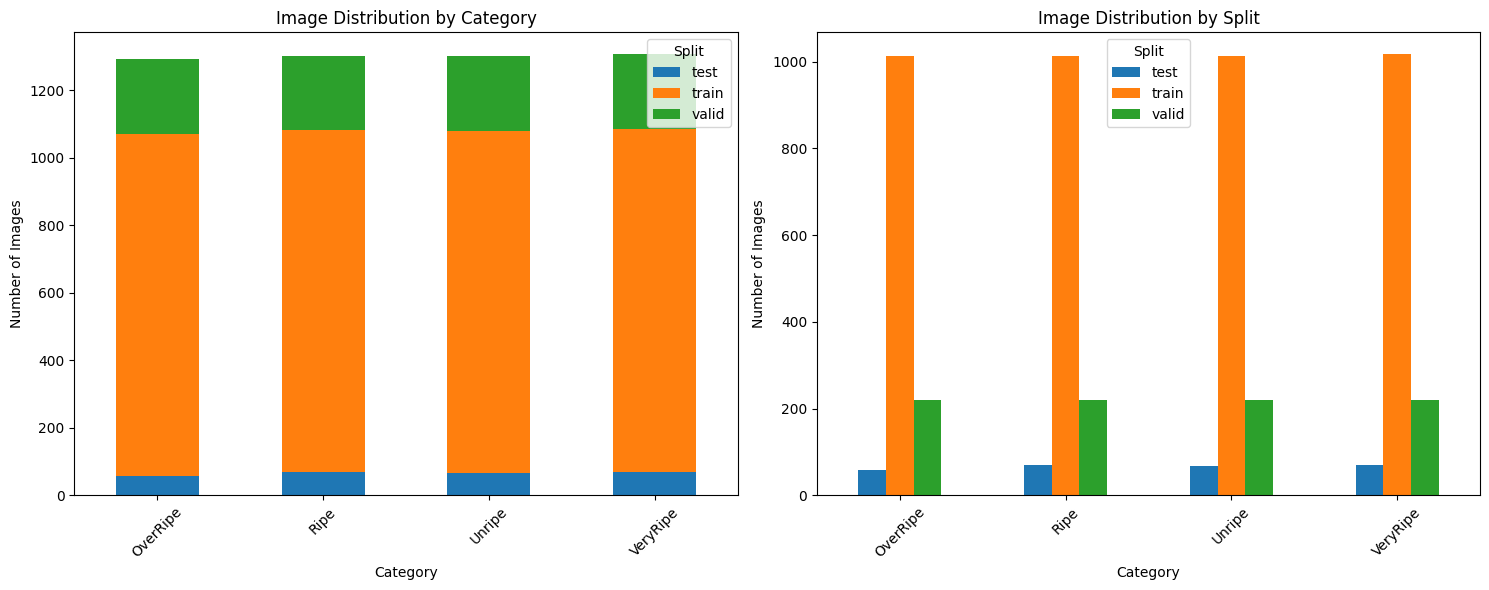

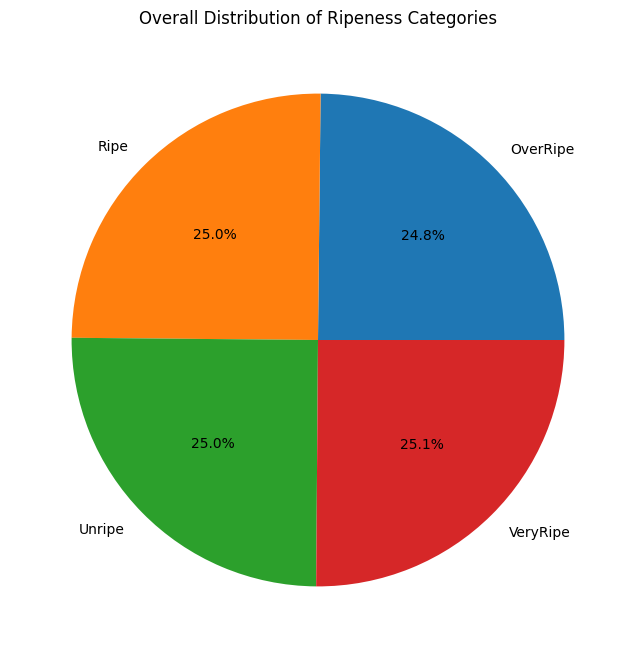


Detailed distribution saved to 'tomato_dataset_distribution.csv'


In [3]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

def mount_drive():
    """Mount Google Drive"""
    try:
        drive.mount('/content/drive', force_remount=True)
        print("Drive mounted successfully")
    except Exception as e:
        print(f"Error mounting drive: {str(e)}")
        return False
    return True

def rename_mismatched_images(base_path):
    """
    Rename images where the prefix doesn't match the folder name
    """
    categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']
    splits = ['test', 'train', 'valid']
    renamed_count = 0

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue

        for category in categories:
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                continue

            # Get all image files
            image_files = [f for f in os.listdir(category_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for image_file in image_files:
                # Check if image filename starts with a different category name
                for other_category in categories:
                    if image_file.startswith(other_category + '_') and other_category != category:
                        # Create new filename with correct category prefix
                        new_name = category + '_' + image_file[len(other_category + '_'):]
                        old_path = os.path.join(category_path, image_file)
                        new_path = os.path.join(category_path, new_name)

                        try:
                            os.rename(old_path, new_path)
                            print(f"Renamed: {image_file} -> {new_name}")
                            renamed_count += 1
                        except Exception as e:
                            print(f"Error renaming {image_file}: {str(e)}")

    print(f"\nTotal files renamed: {renamed_count}")
    return renamed_count

def verify_folder_structure(base_path):
    """
    Verify the folder structure exists and is correct
    """
    required_splits = ['test', 'train', 'valid']
    required_categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']

    if not os.path.exists(base_path):
        print(f"Error: Base directory not found at {base_path}")
        return False

    structure_valid = False
    for split in required_splits:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            structure_valid = True
            print(f"Found {split} directory")
            for category in required_categories:
                category_path = os.path.join(split_path, category)
                if os.path.exists(category_path):
                    print(f"  ├── Found {category} category")
                else:
                    print(f"  ├── Missing {category} category")
        else:
            print(f"Missing {split} directory")

    return structure_valid

def count_banana_images(base_path):
    """
    Count images in each ripeness category across train, valid, and test folders.
    """
    categories = ['OverRipe', 'Ripe', 'Unripe', 'VeryRipe']
    splits = ['test', 'train', 'valid']
    counts_data = []

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split} folder not found at {split_path}")
            continue

        for category in categories:
            category_path = os.path.join(split_path, category)
            if os.path.exists(category_path):
                image_count = len([f for f in os.listdir(category_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

                counts_data.append({
                    'Split': split,
                    'Category': category,
                    'Count': image_count
                })
            else:
                print(f"Warning: {category} folder not found in {split}")
                counts_data.append({
                    'Split': split,
                    'Category': category,
                    'Count': 0
                })

    return pd.DataFrame(counts_data)

def print_summary(df):
    """Print a detailed summary of the image counts"""
    if df.empty or df['Count'].sum() == 0:
        print("No images found in the dataset.")
        return

    print("\n=== Banana Ripeness Dataset Summary ===\n")
    total_images = df['Count'].sum()
    print(f"Total images in dataset: {total_images}")

    print("\nImages by split:")
    split_summary = df.groupby('Split')['Count'].sum()
    for split, count in split_summary.items():
        if count > 0:
            print(f"{split}: {count} images ({count/total_images*100:.1f}%)")

    print("\nImages by category:")
    category_summary = df.groupby('Category')['Count'].sum()
    for category, count in category_summary.items():
        if count > 0:
            print(f"{category}: {count} images ({count/total_images*100:.1f}%)")

    print("\nDetailed breakdown by split and category:")
    pivot_table = df.pivot(index='Category', columns='Split', values='Count').fillna(0)
    print(pivot_table)

def plot_distribution(df):
    """Create visualizations of the dataset distribution"""
    if df.empty or df['Count'].sum() == 0:
        print("No data to visualize.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    df_pivot = df.pivot(index='Category', columns='Split', values='Count').fillna(0)
    df_pivot.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Image Distribution by Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Number of Images')
    ax1.legend(title='Split')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    df_pivot.plot(kind='bar', ax=ax2)
    ax2.set_title('Image Distribution by Split')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Number of Images')
    ax2.legend(title='Split')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    category_totals = df.groupby('Category')['Count'].sum()
    if category_totals.sum() > 0:
        plt.pie(category_totals, labels=category_totals.index, autopct='%1.1f%%')
        plt.title('Overall Distribution of Ripeness Categories')
        plt.show()

def main():
    # Mount Google Drive
    if not mount_drive():
        return None

    # Define base directory
    base_dir = Path('/content/drive/MyDrive/SeniorProject/Tomato/RipenessClassification_Sorted')

    # Verify folder structure
    print("\nVerifying folder structure...")
    if not verify_folder_structure(str(base_dir)):
        print("\nError: Invalid folder structure. Please check your paths and folder organization.")
        return None

    # Rename mismatched images
    print("\nChecking and renaming mismatched images...")
    renamed_count = rename_mismatched_images(str(base_dir))
    if renamed_count > 0:
        print(f"Successfully renamed {renamed_count} images")

    # Get counts
    print("\nCounting images in dataset...")
    counts_df = count_banana_images(str(base_dir))

    if counts_df.empty or counts_df['Count'].sum() == 0:
        print("No images found in the dataset. Please check your folder structure and paths.")
        return None

    # Print summary
    print_summary(counts_df)

    # Plot distribution
    plot_distribution(counts_df)

    # Save detailed report
    try:
        counts_df.to_csv('tomato_dataset_distribution.csv', index=False)
        print("\nDetailed distribution saved to 'tomato_dataset_distribution.csv'")
    except Exception as e:
        print(f"\nError saving CSV file: {str(e)}")

    return counts_df

if __name__ == "__main__":
    counts_df = main()
